In [1]:
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import sys
import numpy as np
import sklearn as sklearn
import os
import scipy
from scipy import stats
from tqdm import tqdm
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_squared_error
from tools_AA_IR import get_tif, reading_gps_file
from tools_AA import slice_raw, path_sonde
from tools_EL import readingtemp
from scipy.optimize import minimize
import geostatspy.geostats as geostats 

In [2]:
def dict_temp_sensor_function(date_1,date_2) :
    """
    fonction créant un dictionnaire regroupant les DATAFRAMES tronquées aux dates souhaitées 
    """
    
    ls_path = path_sonde()
    dict_temp_sensor = {}
    for i,ls_path_sonde in enumerate(ls_path):
        name = ls_path_sonde[0][ls_path_sonde[0].find("S"):(ls_path_sonde[0].find(".csv"))]
        Raw = readingtemp(ls_path_sonde[0])
        if name == "S3AIR" : #différence entre le nom du fichier et le reste du code.
            name = "S3-AIR"
        dict_temp_sensor[name] = slice_raw(Raw,date_1,date_2)
        print("completed :",name)
    
    return dict_temp_sensor

    

In [3]:
def Import_variogram(REQUESTED_IR,TEMP,TYPE) :
    """
    Importation des données de variogrammes pré-calculés
    variogram : dictionnaire contenant différents données issus du calcul des variogrammes
    DataFrame : DataFrame contenant positions + valeurs 
    varc      : Variogrammes aux formats DataFrames
    """
    if TYPE == "Primary" :
        filename  = "./varr/Primary_variogram/Boucle/"+str(REQUESTED_IR)+"_"+str(TEMP)+".npy"
        variogram = np.load(filename,allow_pickle='TRUE').item()
        DataFrame = variogram["DataFrame"]
        varc      = variogram["Variogram"]
    
    elif TYPE == "Secondary" :
        filename  = "./varr/Secondary_variogram/Boucle/"+str(REQUESTED_IR)+"_convex.npy"
        variogram = np.load(filename,allow_pickle='TRUE').item()
        DataFrame = variogram["DataFrame"]
        varc      = variogram["Variogram"]
        
    elif TYPE == "Cross" :
        filename  = "./varr/Cross_variogram/Boucle/"+str(REQUESTED_IR)+"_"+str(TEMP)+".npy"
        variogram = np.load(filename,allow_pickle='TRUE').item()
        DataFrame = variogram["DataFrame"]
        varc      = variogram["Variogram"]
        
    return variogram,DataFrame,varc
        
        

# Loading

### Importation des données

In [4]:
dict_IR_Df = np.load("dict_IR_Df.npy",allow_pickle='TRUE').item()
dict_IR_Df.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [5]:
REQUESTED_IR = "IR_9H28"
TEMP = "T4"

### Données de température (Z)

In [6]:
Primary_variogram,Primary,varc_1 = Import_variogram(REQUESTED_IR,TEMP,"Primary") 

In [7]:
Primary_variogram.keys()

dict_keys(['DataFrame', 'Variogram', 'sensor', 'IR_time'])

In [8]:
original_variance_z = Primary_variogram["DataFrame"]["T4"].var()
original_mean_z = Primary_variogram["DataFrame"]["T4"].mean()

In [9]:
## En cas de sauvegarde, comparaison sur Surfer
condition = False
if condition :
    Primary_variogram["DataFrame"].to_csv("test_krg.csv")

### Données du drone (Y)

In [10]:
Secondary_variogram,Secondary,varc_2 = Import_variogram(REQUESTED_IR,TEMP,"Secondary") 

In [11]:
Secondary_variogram.keys()

dict_keys(['DataFrame', 'Variogram', 'enchantillonage', 'IR_time'])

In [12]:
Secondary_variogram["DataFrame"].head()

,X,Y,band 1,Secondary
0,523628.71,5.366179e+06,7.416178,0.173200
1,523628.71,5.366184e+06,8.905461,1.263792
2,523628.71,5.366189e+06,7.845994,0.487952
3,523628.71,5.366194e+06,7.296544,0.085593
4,523628.71,5.366200e+06,5.825562,-0.991596


In [13]:
original_variance_y = Secondary_variogram["DataFrame"]["band 1"].var()
original_mean_y = Secondary_variogram["DataFrame"]["band 1"].mean()

In [14]:
Secondary_variogram["enchantillonage"]

100

### Données croisées

In [15]:
Cross_variogram,Cross,varc_3 = Import_variogram(REQUESTED_IR,TEMP,"Cross") 

In [16]:
Cross_variogram.keys()

dict_keys(['DataFrame', 'Variogram', 'sensor', 'IR_time'])

In [17]:
value_z = Primary["Primary"].values
varr_z = np.var(value_z) # Variance 
varr_z = float("{:.2f}".format(varr_z))
print("Variance of Z :", varr_z)

Variance of Z : 1.0


In [18]:
value_y = Secondary["Secondary"].values
varr_y = np.var(value_y) # Variance 
varr_y = float("{:.2f}".format(varr_y))
print("Variance of Y :",varr_y)

Variance of Y : 1.0


In [19]:
value_c = Cross["Secondary"].values
varr_c = np.corrcoef(Cross["Primary"], Cross["Secondary"])[0, 1]
print("Cross Correlation coefficient :",varr_c)

Cross Correlation coefficient : 0.871623491845341


## Visualisation des Correlogrammes

In [20]:
Primary["Primary"].values

array([ 1.65467602,  0.2028511 , -0.99480555,  0.1979062 ,  1.54391009,
       -0.26295921, -0.08889845, -0.81481091, -1.43786929])

In [21]:
condition = False
if condition :
    
    ones = np.zeros(shape=(100))
    Cross_ones = np.zeros(shape=(100))
    H = np.zeros(shape=(100))
    Corr_labels = [
        "Primary Correlogram",
        "Secondary Correlogram",
        "Cross Correlogram",
    ]
    Directions = ["Major", "Minor"]
    colors = ["Grey", "Blue", "Orange"]
    labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]
    Sill_vals = [varr_z, varr_y, varr_c]
    for h in range(1, 100):
        H[h] = h
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i in range(0, 3):
        var = locals()["varc_{}".format(i + 1)]
        for j in range(0, 2):
            axes[j, i].plot(
                var["Lag Distance"][var["Variogram Index"] == (j + 1)],
                Sill_vals[i]
                - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
                "o",
                color=colors[i],
            )
            axes[j, i].set_ylabel(labels_2[i], size=35)
            axes[j, i].plot(H, ones, color="Black")
            axes[j, i].set_xlabel("h", size=35)
            axes[j, i].set_title(Corr_labels[i] + " " + Directions[j] +"\n"+ REQUESTED_IR +' : '+ TEMP, size=15)
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

    #plt.savefig('true_variograms.png', bbox_inches="tight", dpi=300)

## Boucle Boucle Boucle

In [22]:
condition = False
if condition :  
    for requested_IR in dict_IR_Df :
        for temp in ["T1","T2","T3","T4"] :
            Primary_variogram,Primary,varc_1 = Import_variogram(requested_IR,temp,"Primary") 
            Secondary_variogram,Secondary,varc_2 = Import_variogram(requested_IR,temp,"Secondary") 
            Cross_variogram,Cross,varc_3 = Import_variogram(requested_IR,temp,"Cross") 
            value_z = Primary["Primary"].values
            varr_z = np.var(value_z) # Variance 
            varr_z = float("{:.2f}".format(varr_z))

            value_y = Secondary["Secondary"].values
            varr_y = np.var(value_y) # Variance 
            varr_y = float("{:.2f}".format(varr_y))

            value_c = Cross["Secondary"].values
            varr_c = np.corrcoef(Cross["Primary"], Cross["Secondary"])[0, 1]
            print("Cross Correlation coefficient,",requested_IR,temp,":",varr_c)

            ones = np.zeros(shape=(100))
            Cross_ones = np.zeros(shape=(100))
            H = np.zeros(shape=(100))
            Corr_labels = [
                "Primary Correlogram",
                "Secondary Correlogram",
                "Cross Correlogram",
            ]
            Directions = ["Major", "Minor"]
            colors = ["Grey", "Blue", "Orange"]
            labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]
            Sill_vals = [varr_z, varr_y, varr_c]
            for h in range(1, 100):
                H[h] = h
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            for i in range(0, 3):
                var = locals()["varc_{}".format(i + 1)]
                for j in range(0, 2):
                    axes[j, i].plot(
                        var["Lag Distance"][var["Variogram Index"] == (j + 1)],
                        Sill_vals[i]
                        - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
                        "o",
                        color=colors[i],
                    )
                    axes[j, i].set_ylabel(labels_2[i], size=20)
                    axes[j, i].plot(H, ones, color="Black")
                    axes[j, i].set_xlabel("h", size=20)
                    axes[j, i].set_title(Corr_labels[i] + " " + Directions[j] +"\n"+ requested_IR +' : '+ temp, size=15)
            plt.setp(axes, xlim=(0, 100),ylim=(-0.3, 1))
            plt.subplots_adjust(wspace=0.4,hspace=0.4)

            SAVE = True
            if SAVE :
                fileout = "./varr/Correlogram_export/"+str(requested_IR)+"_"+str(temp)+".png"
                plt.savefig(fileout, bbox_inches="tight")

## Initialize Correlogram Types 

In [23]:
def covar(t, d, r):
    h = d / r
    if t == 1:  # Spherical
        c = (1 - h * (1.5 - 0.5 * np.square(h)))
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = (np.exp(-3 * h))
    elif t == 3:  # Gaussian
        c = (np.exp(-3 * np.square(h)))
    return c

In [24]:
def Rot_Mat(Azimuth, a_max, a_min):
    theta = (Azimuth / 180.0) * np.pi
    Rot_Mat = np.dot(
        np.array([[1 / a_max, 0], [0, 1 / a_min]]),
        np.array(
            [
                [np.cos(theta), np.sin(theta)],
                [-np.sin(theta), np.cos(theta)],
            ]
        ),
    )
    return Rot_Mat

### Pré-allocation des matrices

In [116]:
# Define some matrices for storing variogram values
LENGTH = 100
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
H = np.zeros(shape=(LENGTH + 1))
ones = np.zeros(shape=(LENGTH + 1))
Sill_vals = [varr_z,varr_y,1] ## !!

### Plottting labels 
colors = ["Red", "Green"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]

Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram"]

labels_1 = [
    "$\hat{\u03C1_{z}}$",
    "$\hat{\u03C1_{y}}$",
    "$\hat{\u03C1_{zy}}$",
]
labels_MM = [
    "$\u03C1_{z_{Model}}$",
    "$\u03C1_{y_{Model}}$",
    "$\u03C1_{z_{MMII}}$",
]

Cross_ones = np.zeros(shape=(101))


# Single Model  (Z)

### Correlogram function  (Z)

In [117]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_alternate(h1, h2, k,a_max,a_min,vtype = [3],cc = [1],nstruct = 1):
    C = []
    #nstruct = 1
    #vtype = [3] 
    #a_max = [24]
    #a_min = [16]
    Azimuth = 45
    #cc = [1]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i] 
    return c

### Minimize function  (Z)

In [118]:
def optimize_RMSE_single_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*spherical(a_min,a_max)
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    t = args[2] # chosit le type de model
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major"]
    
    for i,Dir in enumerate(Direction) :
        c = [] # liste des covario
        a_range = x[0] # range
        b = x[1]       # effet pépite
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag / a_range # valeurs des lags / range
        
        
        for h in lag_value:
            if t == "Spherical":  # Spherical
                if h > 1.0 :
                    MODEL = 0
                else :
                    MODEL = b* (1 - h * (1.5 - 0.5 * np.square(h)))
                
            elif t == "Exponentiel" :  # Exponential
                MODEL = b* (np.exp(-3 * h))
            elif t == "Gaussien":  # Gaussian
                MODEL = b*(np.exp(-3 * np.square(h)))
                
            c.append(MODEL)
            
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
        
    return sum(RMSE)

In [119]:
MODEL_type = ["Spherical","Exponentiel","Gaussien"]  # Type de model

# Allocation des constantes 
a_max0, b0 = 100, 1 # range , effet pepite
x0 = np.array([a_max0, b0])
Model_name =  MODEL_type[1] # Model type

var, Sill_value,= varc_1, Sill_vals[0] # variogram , Variance
args = np.array([var,Sill_value,Model_name])

# Boundaries 
Bounds = [[1,150], [0,5]]

# Minimize
single_model = minimize(optimize_RMSE_single_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

a_max_z, b_z = single_model.x
a_min_z = a_max_z
print(single_model)

#Réduit la précision des variables 
name_var = ["a_max_z", "b_z"]
number_var = [a_max_z, b_z]
for name,number in zip(name_var,number_var) :
    
    if name == "b_z" :
        locals()[f"{name}"] = float("{:.2f}".format(number))
    else :
        locals()[f"{name}"] = float("{:.0f}".format(number))
    print(name,":",locals()[f"{name}"])

     fun: 0.5535809194895587
     jac: array([-2.30917206e-07, -8.51098404e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 130
     nit: 10
  status: 1
 success: True
       x: array([40.34420621,  2.98176316])
a_max_z : 40.0
b_z : 2.98


###  Visualisation du model Z

In [120]:
MODEL ={"Spherical" : 1,
        "Exponentiel" : 2,
        "Gaussien" : 3} # Type de model
a_max = a_max_z
a_min = a_max_z
cc_z = [b_z]
vtype_z = [MODEL[Model_name]] # !!! # Type de model

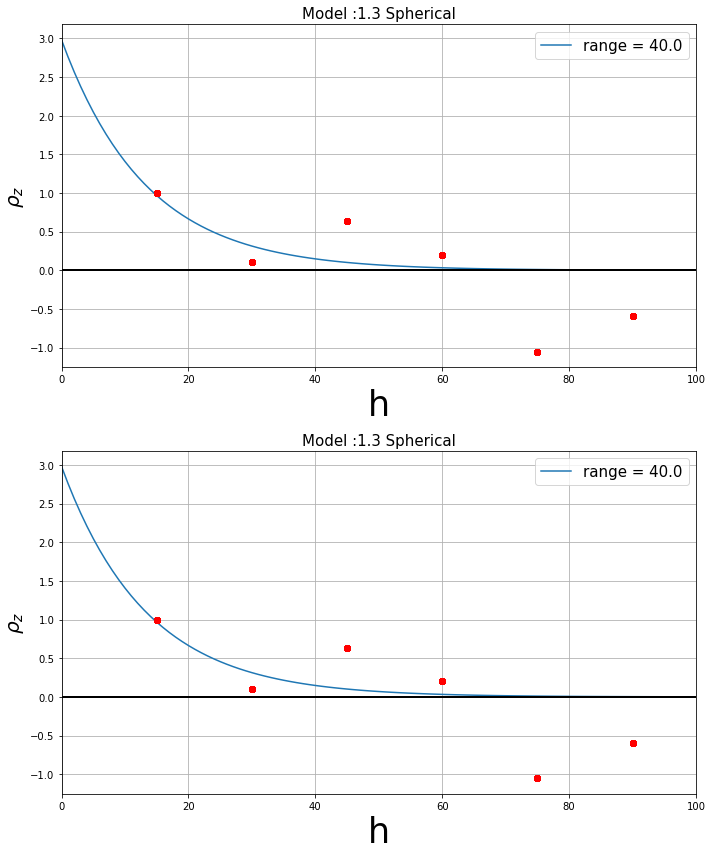

In [121]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction

fig, axes = plt.subplots(2,1, figsize=(10, 12))

for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,[a_max],[a_min],vtype_z,cc_z)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [0]:
        LABEL =  "range = {}".format(a_max)
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        for j in np.arange(1):
            axes[s].plot(
                var["Lag Distance"][var["Variogram Index"] == (j + 1)],
                Sill_vals[i]
                - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
                "o",
                color=colors[i],
            )
            axes[s].set_ylabel(labels_2[i], size=20)
            axes[s].plot(H, ones, color="Black")
            axes[s].set_xlabel("h", size=35)
            axes[s].set_title("Model :1.3 Spherical", size=15)
            axes[s].legend(loc="best", prop={"size": 15})
            axes[s].grid()
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

# Dual Model  (Y)

In [122]:
varc_2.head()

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
0,1.0,0.0,NaN,1.0
1,2.0,123771.0,0.367115,1.0
2,3.0,243738.0,0.416298,1.0
3,4.0,330006.0,0.459650,1.0
4,5.0,384205.0,0.504366,1.0


### Correlogram function  (Y)

In [123]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y_alternate(h1, h2, k,a_max,a_min,cc = [1],vtype = [1],nstruct = 1):
    C = []
    #nstruct = 2
    #vtype = [1,3]
    #a_max = [42, 43]
    #a_min = [28.5, 30]
    Azimuth = 45
    #cc = 0.6,0.4
    c = 0.0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                )
            ).sum(axis=1)
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1)  * cc[i]

    return c

### Minimize function  (Y)

In [124]:
def optimize_RMSE_dual_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    var = var.dropna(axis = 0)
    Sill_value = args[1]
    t = args[2] # chosit le type de model
    RMSE = [] # Liste des RMSE
    Direction = ["Major", "Minor"] #Deux directions à additionner
    
    for i,Dir in enumerate(Direction) :
        cov = []              # liste des covario
        a_first = x[i]        # range du 1e model
        a_second = x[2+i]     # range du 2nd model
        b = x[4]              # effet pépite n1
        c = 0
        if len(t) > 1 :
            c = np.absolute(1-b)  # effet pépite n2
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value_first = variogram_lag / a_first # valeurs des lags / range
        lag_value_second = variogram_lag / a_second # valeurs des lags / range
        
        for h_first,h_second in zip(lag_value_first,lag_value_second):
            model_value = []
            model_h = [h_first,h_second]
            model_nugget = [b,c]
            
            for model_type, nugget, h in zip(t, model_nugget, model_h) :
                if model_type == "Spherical":  # Spherical
                    if h > 1.0 :
                        model_value.append(0)
                    else :
                        model_value.append(nugget * (1 - h * (1.5 - 0.5 * np.square(h))))
                elif model_type == "Exponentiel" :  # Exponential
                    
                    model_value.append(nugget * (np.exp(-3 * h)))
                    
                elif model_type == "Gaussien":  # Gaussian
                    model_value.append(nugget *(np.exp(-3 * np.square(h))))
        
            cov.append(model_value)
            
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,cov)))
    return sum(RMSE)

In [125]:
# Allocation des constantes 
# b0 : effet pepite du model 1
#a_max_first0, a_min_first0,a_max_second0, a_min_second0, b0 = 42, 28.5, 43, 30, 1

MODEL_type = ["Spherical","Exponentiel","Gaussien"] 
MODEL_value = [MODEL_type[0]]

a_max_first0, a_min_first0,a_max_second0, a_min_second0, b0 = 10, 5, 20, 15, 0.5
x0   = np.array([a_max_first0, a_min_first0,a_max_second0, a_min_second0, b0])

var, Sill_value, Model = varc_2, Sill_vals[1] , MODEL_value
args = np.array([var,Sill_value,Model])

# Boundaries 
Bounds = [[1,200], [1,200], [1,200], [1,200], [0,10]] # a_max_first0, a_min_first0,a_max_second0, a_min_second0, b0, c0

# Minimize
options = {"xtol" : 1e-5,
           "gtol" : 1e-5}

dual_model = minimize(optimize_RMSE_dual_model, x0, args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,
                      tol = 1e-9, options = options)

a_max_first, a_min_first, a_max_second, a_min_second, b_y= dual_model.x
c_y = 1-b_y
print(dual_model,'\n')
#Réduit la précision des variables 
name_var = ["a_max_first", "a_min_first", "a_max_second", "a_min_second","b_y","c_y"]
number_var = [a_max_first, a_min_first, a_max_second, a_min_second, b_y,c_y]

for name,number in zip(name_var,number_var) :
    if name == "b_y" or name == "c_y" :
        locals()[f"{name}"] = float("{:.1f}".format(number))
    else :
        locals()[f"{name}"] = float("{:.0f}".format(number))
    print(name,":",locals()[f"{name}"])

     fun: 0.0797226551863041
     jac: array([1.68312371e-07, 1.13423740e-07, 0.00000000e+00, 0.00000000e+00,
       5.72960771e-06])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 385
     nit: 8
  status: 1
 success: True
       x: array([41.50900361, 49.97970096, 20.        , 15.        ,  0.55789573]) 

a_max_first : 42.0
a_min_first : 50.0
a_max_second : 20.0
a_min_second : 15.0
b_y : 0.6
c_y : 0.4


### Plot fitted Correlogram (Y)

In [126]:
MODEL ={"Spherical" : 1,
        "Exponentiel" : 2,
        "Gaussien" : 3}

Direction = ["Major", "Minor"]

a_max_y = [a_max_first, a_max_second]
print("a_max :", a_max)
a_min_y = [a_min_first, a_min_second]
print("a_min :", a_min)
cc_y = [b_y, c_y]

a_max : 40.0
a_min : 40.0


In [127]:
vtype_y = []
for model_value in Model :
    vtype_y.append(MODEL[model_value]) # type de modèle 
print(vtype_y)

[1]


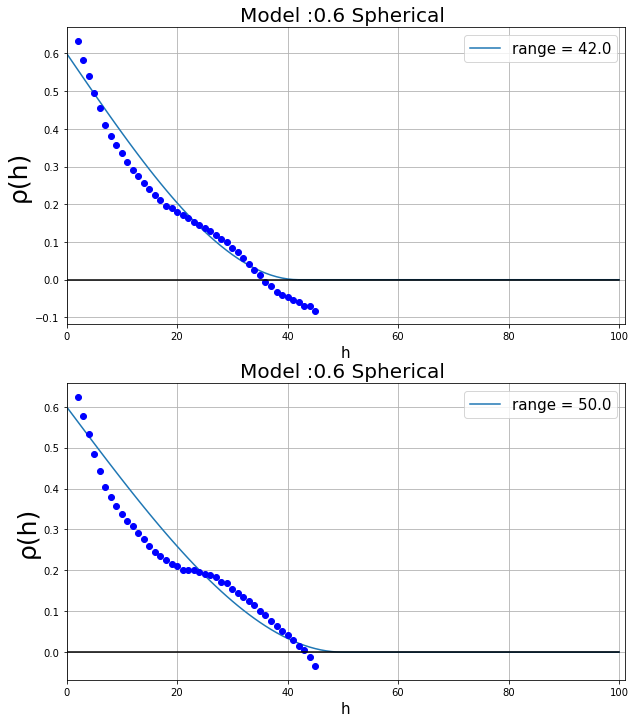

In [128]:
k = 0
varg_type = 2  # See Correlogram Functions
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

for Dir in Direction:
    
    for h in range(0, LENGTH + 1):
        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,
                                       a_max_y,a_min_y,
                                       cc_y, vtype_y, nstruct = 1)
        H[h] = h
    MM_vargs = [ cz_True,cy,czy ]

    for i in np.arange(1,2): 
        if Dir == "Major" : 
            LABEL =  "range = {}".format(a_max_y[0])
        else :
            LABEL =  "range = {}".format(a_min_y[0])
        axes[k].plot(H, MM_vargs[i], label=LABEL)
        
        if (i + 1) < 3:
            var = locals()["varc_{}".format(i + 1)]
            axes[k].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color="blue"
                )
    
    TITLE = "Model :"
    for i in range(1) :
        TITLE += f"{cc_y[i]} {MODEL_type[vtype_y[i]-1]} "
        
    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    #axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=25)
    axes[k].set_xlabel("h", size=15)
    axes[k].set_title(TITLE,size=20)
    axes[k].legend(loc="best", prop={"size": 15})
    varg_type = varg_type + 1
    k +=1
    
Save = False 
if Save :
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/Correlogram_test/"+Model+".png"
    plt.tight_layout()
    plt.savefig('fileout', bbox_inches="tight", dpi=300)
    

# Cross Model 

### Correlogram function  (Cross)

In [129]:
def C_ZY(h1, h2, k, a_max, a_min, corr,vtype,nstruct ):
    C = []
    #nstruct = 1
    #vtype = [1]
    #a_max = [45]
    #a_min = [30]
    Azimuth = 45
    cc = [corr]
    c = 0
    for i in range(nstruct):
        
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### Minimize function  (Cross)

In [130]:
def optimize_RMSE_cross(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*spherical(a_min,a_max)
    """
    
    var = args[0][args[0]["Variogram Value"] != -999] # drop les valeurs -999 
    Sill_value = args[1]
    t = args[2] # chosit le type de model
    RMSE = [] # Liste des RMSE
    Direction = ["Major","Minor"] #deux directions à additionner
    
    for i,Dir in enumerate(Direction) :
        c = [] # liste des covario
        a_range = x[0] # range
        b = Sill_value      # effet pépite
        #print(a_range , b)
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag / a_range # valeurs des lags / range
        
        
        for h in lag_value:
            
            if t == "Spherical":  # Spherical
                if h > 1.0 :
                    MODEL = 0
                else :
                    MODEL = b* (1 - h * (1.5 - 0.5 * np.square(h)))
                
            elif t == "Exponentiel" :  # Exponential
                MODEL = b* (np.exp(-3 * h))
            elif t == "Gaussien":  # Gaussian
                MODEL = b*(np.exp(-3 * np.square(h)))
                
            c.append(MODEL)
            
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
        #print("sum(RMSE) :", sum(RMSE), "\n")
    return sum(RMSE)

In [131]:
Primary = Cross_variogram["DataFrame"]
corr = np.corrcoef(Primary["Primary"], Primary["Secondary"])[0,1]
corr = float("{:.2f}".format(corr))
print("Coeff de correlation :", corr)

Model = ["Spherical","Exponentiel","Gaussien"]

# Allocation des constantes 
a_max0 = 10
x0 = np.array(a_max0)
Model_name = Model[2]

var, Sill_value  = varc_3, corr
args = np.array([var,Sill_value,Model_name])

# Boundaries 
Bounds = [[1,50]]
# Minimize
single_model = minimize(optimize_RMSE_cross,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

a_max_zy = single_model.x
a_min_zy = a_max_zy
print(single_model,'\n')
b_zy = Sill_value
#Réduit la précision des variables 
name_var = ["a_max_c", "b_c"]
number_var = [a_max_zy[0],a_min_zy[0], b_zy]

for name,number in zip(name_var,number_var) :
    if name == "b_zy" :
        locals()[f"{name}"] = float("{:.2f}".format(number))
    else :
        locals()[f"{name}"] = float("{:.0f}".format(number))
    print(name,":",locals()[f"{name}"])

Coeff de correlation : 0.87
     fun: 1.2776992566890353
     jac: array([-0.00398874])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 9
     nit: 1
  status: 0
 success: True
       x: array([50.]) 

a_max_c : 50.0
b_c : 50.0


### Plot fitted Cross Correlogram

In [132]:
MODEL ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}
MODEL_TYPE = {1 : "Spherical" ,
        2 : "Exponential" ,
        3 : "Gaussien" }
Direction = ["Major", "Minor"]

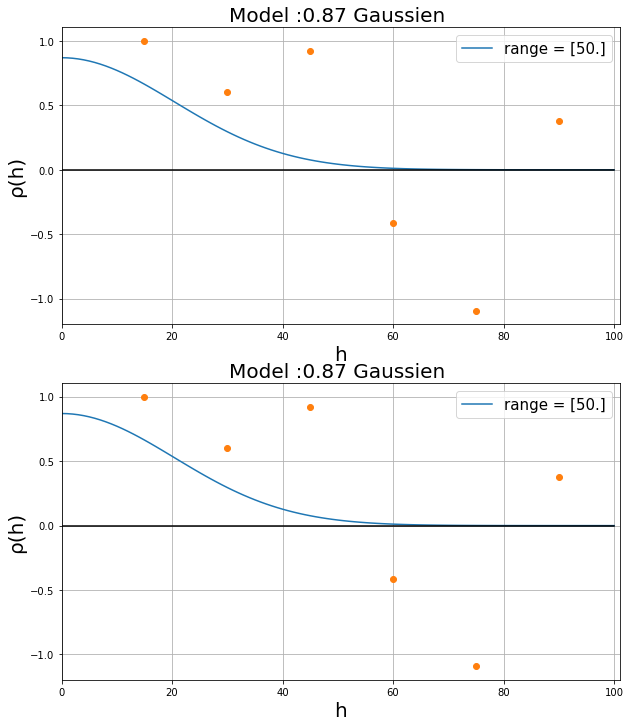

In [133]:
## Constantes de démarrage
varg_type_cc = 2  # See Correlogram Functions
a_max = [a_max_zy]
a_min = [a_max_zy]
cc_zy = corr
vtype_zy = [3]# type de modèle 
k = 0
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

for Dir in Direction:
    
    for h in range(0, LENGTH + 1):
        czy[h]= C_ZY(np.matrix(h), np.matrix(h), 2,
                                       a_max,a_min,
                                       cc_zy, vtype_zy,  1)
        H[h] = h
    MM_vargs = [ cz_True,cy,czy ]

    for i in np.arange(2,3): 
        if Dir == "Major" : 
            LABEL =  "range = {}".format(a_max[0])
        else :
            LABEL =  "range = {}".format(a_min[0])
        axes[k].plot(H, MM_vargs[i], label=LABEL)
        
        if (i + 1) <= 3:
            var = locals()["varc_{}".format(i + 1)]
            axes[k].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type_cc - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type_cc - 1)
                ],
                "o"
                )
    
    TITLE = "Model :"
    for i in range(len([cc_zy])) :
        TITLE += f"{cc_zy} {Model_name} "
        
    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    #axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=20)
    axes[k].set_xlabel("h", size=20)
    axes[k].set_title(TITLE,size=20)
    axes[k].legend(loc="best", prop={"size": 15})
    varg_type_cc = varg_type_cc + 1
    k +=1
    
Save = False 
if Save :
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/Correlogram_test/"+Model+".png"
    plt.tight_layout()
    plt.savefig('fileout', bbox_inches="tight", dpi=300)
    

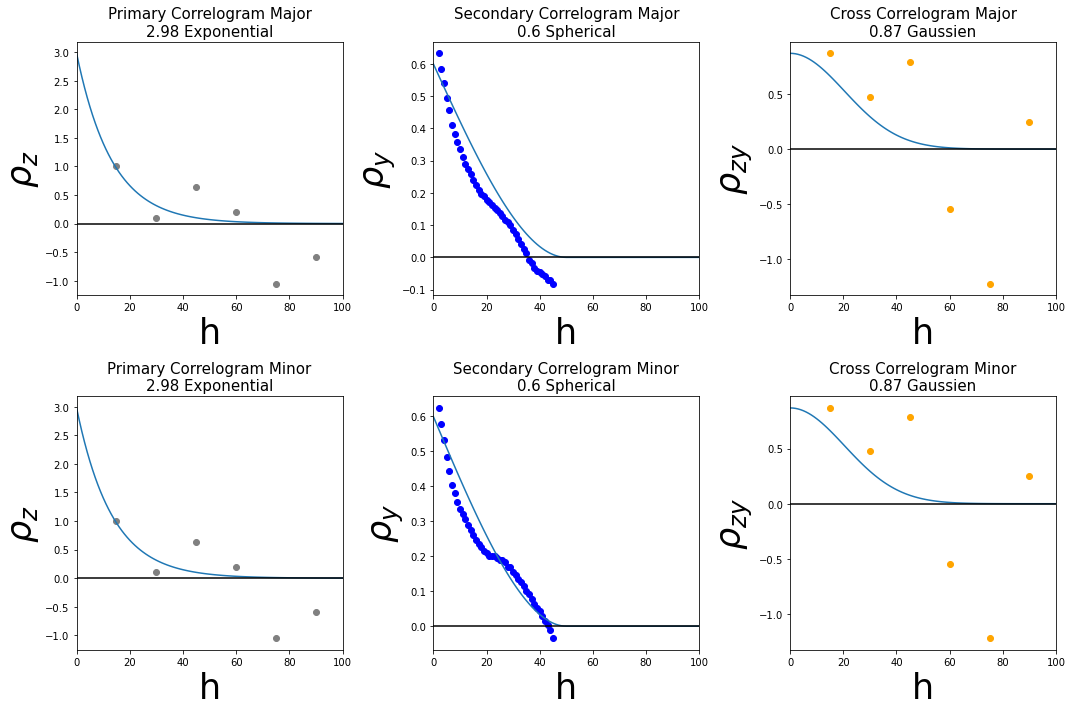

In [134]:
ones = np.zeros(shape=(101))
Cross_ones = np.zeros(shape=(101))
H = np.zeros(shape=(101))
Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram",
]
Directions = ["Major", "Minor"]
Model_name = [MODEL_TYPE[vtype_z[0]],MODEL_TYPE[vtype_y[0]],MODEL_TYPE[vtype_zy[0]]]
b_effect   = [cc_z[0],cc_y[0],cc_zy]

colors = ["Grey", "Blue", "Orange"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]
Sill_vals = [1, 1, corr]
for h in range(1, 101):
    H[h] = h
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
MM_vargs = [ cz_True,cy,czy]
for i in range(0, 3):
    var = locals()["varc_{}".format(i + 1)]
    for j in range(0, 2):
        axes[j, i].plot(
            var["Lag Distance"][var["Variogram Index"] == (j + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
            "o",
            color=colors[i],
        )
        
        
        
        
        axes[j,i].plot(H, MM_vargs[i])
        axes[j, i].set_ylabel(labels_2[i], size=35)
        axes[j, i].plot(H, ones, color="Black")
        axes[j, i].set_xlabel("h", size=35)
        axes[j, i].set_title(Corr_labels[i] + " " + Directions[j] +"\n"+str(b_effect[i])+" "+Model_name[i], size=15)
        
plt.setp(axes, xlim=(0, 100))
plt.tight_layout()
#plt.savefig('true_variograms.png', bbox_inches="tight", dpi=300)

## Set up MMII Correlogram

In MMII the secondary correlogram ρy(h) and the correlation are used to calculate the secondary covariance and the cross covariance. In MMII the primary covariance is fit using ρr(h) and the secondary correlogram ρy(h). The primary correlogram for the MMII is denoted as ρzMMII(h) in the images below. ρzMMII(h) should be similar to ρz(h)

#### Le modèle ρzMMII doit similaire à ρz(h) : On passe obligatoirement par une fonction de minimisation 

### Scalling Correlogram

In [141]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_r (h1, h2, k, a_max, a_min, cc,vtype,nstruct ):
    C = []
    #nstruct = 1
    #vtype = [3]
    #a_max = [18]
    #a_min = [13]
    Azimuth = 45
    #cc = [1]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

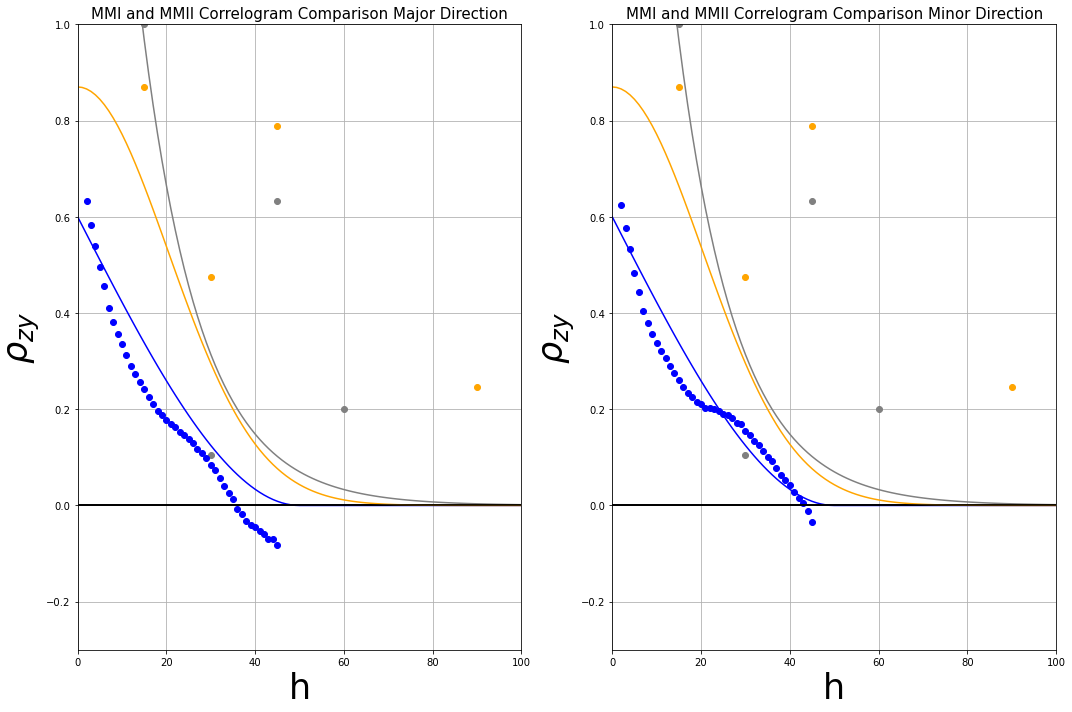

In [139]:
ones = np.zeros(shape=(101))
Cross_ones = np.zeros(shape=(101))
H = np.zeros(shape=(101))
Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram",
]
Directions = ["Major", "Minor"]
Model_name = [MODEL_TYPE[vtype_z[0]],MODEL_TYPE[vtype_y[0]],MODEL_TYPE[vtype_zy[0]]]
b_effect   = [cc_z[0],cc_y[0],cc_zy]

colors = ["Grey", "Blue", "Orange"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]
Sill_vals = [1, 1, corr]
for h in range(1, 101):
    H[h] = h
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
MM_vargs = [ cz_True,cy,czy]
for i in range(0, 3):
    var = locals()["varc_{}".format(i + 1)]
    for j in range(0, 2):
        axes[j].plot(
            var["Lag Distance"][var["Variogram Index"] == (j + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
            "o",
            color=colors[i],
        )
        
        #if Dir == "Major" : 
        #   LABEL =  "range = {}".format(a_max[0])
        #else :
        #    LABEL =  "range = {}".format(a_min[0])
        axes[j].plot(H, MM_vargs[i],color = colors[i])
        axes[j].set_ylabel(labels_2[i], size=35)
        axes[j].plot(H, ones, color="Black")
        axes[j].set_xlabel("h", size=35)
        axes[j].set_title("MMI and MMII Correlogram Comparison {} Direction".format(Directions[j]),size=15)
        axes[j].set_ylim([-0.3,1])
        axes[j].grid()
        
        
plt.setp(axes, xlim=(0, 100))
plt.tight_layout()
#plt.savefig('true_variograms.png', bbox_inches="tight", dpi=300)

### C_Z Correlogram MMII 

In [142]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# Corr = correlation between primary and secondary data
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_MM2(h1, h2, k, corr,a_max_y,a_min_y,cc_y, vtype_y, a_max_r, a_min_r, cc_r,vtype_r ):
    
    return (C_Y_alternate(h1, h2, k,a_max_y,a_min_y,cc_y, vtype_y, nstruct = 1) * corr ** 2) + (
        (1 - corr ** 2) * C_r (h1, h2, k, a_max_r, a_min_r, cc_r,vtype_r,nstruct = 1 )
    )

### Minimize function

In [144]:
def optimize_RMSE_scalling_correlogram(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    """
    
    dict_secondary = args[0]
    Sill_value = args[1]
    vtype = args[2] # chosit le type de model
    RMSE = [] # Liste des RMSE
    Direction = ["Major", "Minor"] #Deux directions à additionner
    a_max_y = dict_secondary["a_max_y"]
    a_min_y = dict_secondary["a_min_y"]
    cc_y    = dict_secondary["cc_y"]
    vtype_y = dict_secondary["vtype_y"]
    
    for i,Dir in enumerate(Direction) :
        
        k = i + 2           # numéro de la direction 
        cov = []            # liste des covario
        a_max = x[0]        # range major du 1e model
        a_min = x[1]        # range minor du 1e model
        
        b = x[2]            # effet pépite n1
            
        model_value = []
        model_h = [h_first]
        model_nugget = [b]
            
            for model_type, nugget, h in zip(t, model_nugget, model_h) :
                for h in range(0, 101):
                    cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                          a_max_y,a_min_y,cc_y, vtype_y, nstruct = 1)
                    
                    cr[h] = C_r(np.matrix(h), np.matrix(h), k,
                                a_max, a_min, cc,vtype,nstruct = 1 )
                    
            cov.append(model_value)
            
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,cov)))
    return sum(RMSE)

0.87

In [ ]:
# Allocation des constantes 
# b0 : effet pepite du model 1
#a_max_first0, a_min_first0,a_max_second0, a_min_second0, b0 = 42, 28.5, 43, 30, 1

MODEL_type = ["Spherical","Exponentiel","Gaussien"] 
MODEL_value = [MODEL_type[0]]

a_max_first0, a_min_first0,a_max_second0, a_min_second0, b0 = 10, 5, 20, 15, 0.5
x0   = np.array([a_max_first0, a_min_first0,a_max_second0, a_min_second0, b0])

var, Sill_value, Model = varc_2, Sill_vals[1] , MODEL_value
args = np.array([var,Sill_value,Model])

# Boundaries 
Bounds = [[1,200], [1,200], [1,200], [1,200], [0,10]] # a_max_first0, a_min_first0,a_max_second0, a_min_second0, b0, c0

# Minimize
options = {"xtol" : 1e-5,
           "gtol" : 1e-5}

dual_model = minimize(optimize_RMSE_dual_model, x0, args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,
                      tol = 1e-9, options = options)

a_max_first, a_min_first, a_max_second, a_min_second, b_y= dual_model.x
c_y = 1-b_y
print(dual_model,'\n')
#Réduit la précision des variables 
name_var = ["a_max_first", "a_min_first", "a_max_second", "a_min_second","b_y","c_y"]
number_var = [a_max_first, a_min_first, a_max_second, a_min_second, b_y,c_y]

for name,number in zip(name_var,number_var) :
    if name == "b_y" or name == "c_y" :
        locals()[f"{name}"] = float("{:.1f}".format(number))
    else :
        locals()[f"{name}"] = float("{:.0f}".format(number))
    print(name,":",locals()[f"{name}"])

In [145]:
varg_type = 2  # See Correlogram Functions
for Dir in Directions:
    for h in range(0, 101):
        
        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,
                                       a_max_y,a_min_y,
                                       cc_y, vtype_y, nstruct = 1)
        
        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,[a_max_z],[a_min_z],vtype_z,cc_z)
        
        cz[h] = C_Z_MM2(np.matrix(h), np.matrix(h), k, corr,a_max_y,a_min_y,cc_y, vtype_y,
                        a_max_r, a_min_r, cc_r,vtype_r )
        
        cr[h] = C_r (np.matrix(h), np.matrix(h), k, a_max_r, a_min_r, cc_r,vtype_r,nstruct = 1 )
        
        H[h] = h
    MM_vargs = [cz_True, cy, cz]
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(0, 3):
        axes.plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 3:
            var = locals()["varc_{}".format(i + 1)]
            axes.plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "ro",
                color=colors[i],
                label=labels_1[i],
            )

    axes.plot(H, ones, color="Black")
    axes.grid()
    plt.xlim(0, 101)
    plt.ylim(-0.1, 1)
    plt.ylabel("\u03C1(h)", size=35)
    plt.xlabel("h", size=35)
    plt.title(
        "MMI and MMII Correlogram Comparison {} Direction".format(Dir),
        size=25,
    )
    axes.legend(loc="best", prop={"size": 35})
    plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1

NameError: name 'a_max_r' is not defined

## Data Statistics

In [46]:
Primary

,SensorName,x,y,T4,Primary,Pseudo_temp,Secondary
0,S10,523628.71,5366296.81,6.209,1.654676,9.199116,1.162678
1,S1,523654.74,5366287.75,4.741,0.202851,6.857671,-0.184485
2,S9,523692.47,5366276.57,3.530,-0.994806,5.911915,-0.728632
3,S2,523660.22,5366258.91,4.736,0.197906,7.403057,0.129306
4,S4,523636.075,5366245.545,6.097,1.543910,9.382530,1.268207
5,S5,523641.825,5366220.67,4.270,-0.262959,8.213127,0.595384
6,S8,523649.33,5366188.02,4.446,-0.088898,8.486796,0.752841
7,S7,523696.655,5366174.0,3.712,-0.814811,4.852900,-1.337942
8,S6,523694.05,5366209.93,3.082,-1.437869,4.297738,-1.657357


In [47]:
Mean_Z = np.average(Primary["Primary"])
STD_Z = 1.0
print(Mean_Z)
print(STD_Z)

7.401486830834377e-17
1.0


In [48]:
Mean_Y = np.average(Primary["Secondary"])
STD_Y = 1.0
print(Mean_Y)
print(STD_Y)

5.674473236973022e-16
1.0


## Create a KDTree to Quickly Get Nearest Points

In [94]:
from sklearn.neighbors import KDTree

In [95]:
def ech_data_kdtree(x,y,z,ech) :
    """
    Fonction qui ré-echantillonne avant l'utilisation d'un KD Tree
    """
    low_quality_secondary = pd.DataFrame()
    x_ech = x[::ech]
    low_quality_secondary["x"] = x_ech
    y_ech = y[::ech]
    low_quality_secondary["y"] = y_ech
    z_ech = z[::ech]
    low_quality_secondary["z"] = z_ech
    
    return low_quality_secondary,x_ech,y_ech,z_ech

In [96]:
Secondary.head()

,X,Y,band 1,Secondary
0,523628.71,5.366179e+06,7.416178,0.173200
1,523628.71,5.366184e+06,8.905461,1.263792
2,523628.71,5.366189e+06,7.845994,0.487952
3,523628.71,5.366194e+06,7.296544,0.085593
4,523628.71,5.366200e+06,5.825562,-0.991596


In [97]:
##MATRICES NON ECHANTILLONEE
x = Secondary["X"].values
y = Secondary["Y"].values
z = Secondary["Secondary"].values

# MATRICES ECHANTILLONEES
ech = 1
df_kriging,x_ech,y_ech,z_ech = ech_data_kdtree(x,y,z,ech)

In [98]:
#Constitution d'un KD Tree, Primary data
datafl_XY = Primary[["x", "y"]].values
datafl = Primary
tree = KDTree(datafl_XY)
Pred_grid_xy = np.matrix([x, y]).T

#Constitution d'un KD Tree, Secondary data
datafl_sec = Secondary
datafl_XY_2nd = Secondary[["X", "Y"]].values
tree_2nd = KDTree(datafl_XY_2nd)

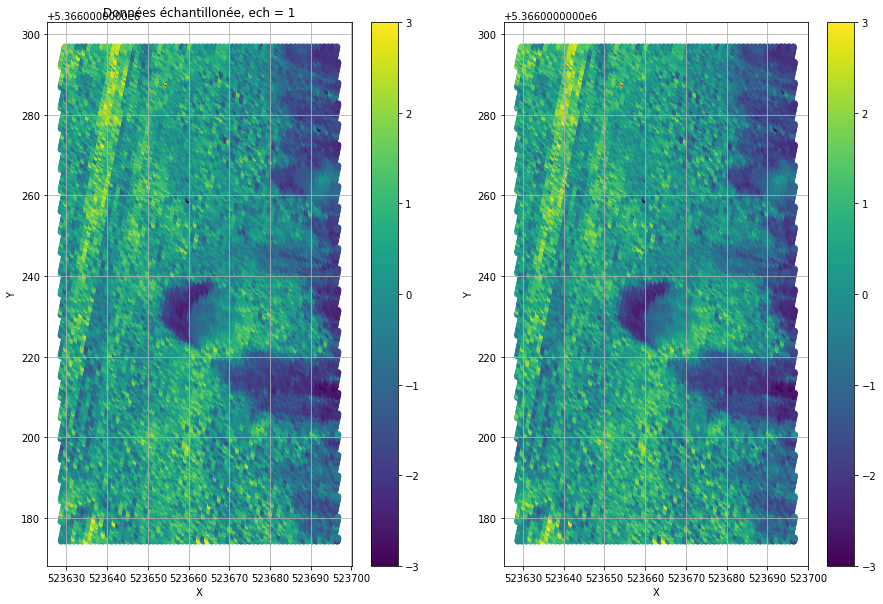

In [99]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,2, figsize = (15,10))
img0 = ax[0].scatter(x_ech, y_ech,c = z_ech , vmin = -3, vmax = 3)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].grid()
ax[0].set_title("Données échantillonée, ech = " + str(ech))
fig.colorbar(img0, ax=ax[0])

img0 = ax[1].scatter(x,y,c = z,vmin = -3, vmax = 3)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].grid()
fig.colorbar(img0, ax=ax[1])


### Primary Data Search for Kriging

In [100]:
k_p = 8  # number of data to use ( limitée au nombre de sonde = 9)
X_Y = np.zeros((len(x), k_p, 2))
X_Y_Star = np.zeros((len(x), k_p, 2))
closematrix_Primary = np.zeros((len(x), k_p))
closematrix_Secondary = np.zeros((len(x), k_p))
neardistmatrix = np.zeros((len(x), k_p))

for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree.query(Pred_grid_xy[i : i + 1, :], k=k_p)
    a = nearest_ind.ravel()
    group = datafl.iloc[a, :]
    closematrix_Primary[i, :] = group["Primary"]
    closematrix_Secondary[i, :] = group["Secondary"]
    neardistmatrix[i, :] = nearest_dist
    X_Y[i, :, :] = group[["x", "y"]]

### Secondary Data Search for CoKriging

In [101]:
X_Y_2nd = np.zeros((len(x), k_p, 2))
closematrix_Secondary_2nd = np.zeros((len(x), k_p))
for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree_2nd.query(
        Pred_grid_xy[i : i + 1, :], k=k_p
    )
    a = nearest_ind.ravel()
    group = datafl_sec.iloc[a, :]
    closematrix_Secondary_2nd[i, :] = group["Secondary"]
    X_Y_2nd[i, :, :] = group[["X", "Y"]]

## Recap des models de variogrammes

In [102]:
print("Premier Correlogram") 
print("a_max_z :",a_max_z,
      "a_min_z :",a_min_z,
      "vtype_z :",vtype_z,
      "cc_z :",cc_z)

Premier Correlogram
a_max_z : 40.0 a_min_z : 40.344206212972516 vtype_z : [2] cc_z : [2.98]


In [103]:
print("Second Correlogram") 
print("a_max_y :",a_max_y,
      "a_min_y :",a_min_y,
      "vtype_y :",vtype_y,
      "cc_y :",cc_y)

Second Correlogram
a_max_y : [42.0, 20.0] a_min_y : [50.0, 15.0] vtype_y : [1] cc_y : [0.6, 0.4]


In [104]:
print("Cross Correlogram") 
print("a_max_zy :",a_max_zy,
      "a_min_zy :",a_min_zy,
      "vtype_zy :",vtype_zy,
      "cc_zy :",cc_zy)

Cross Correlogram
a_max_zy : [50.] a_min_zy : [50.] vtype_zy : [3] cc_zy : 0.87


## Simple Kriging

In [105]:
est_SK = np.zeros(shape=(len(x_ech)))

for z in tqdm(range(0, len(x_ech))):
    Kriging_Matrix = np.zeros(shape=((k_p, k_p)))
    # h = distance_matrix(X_Y[z,:,:].tolist(),X_Y[z,:,:].tolist())
    # C_ZZ
    Kriging_Matrix = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,[a_max_z],[a_min_z],vtype_z,cc_z )
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((k_p)),((k_p))))
    r = np.zeros(shape=(k_p))
    k_p_weights = r
    # RHS #C_z*
    r = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,[a_max_z],[a_min_z],vtype_z,cc_z )
    Kriging_Matrix.reshape(((k_p)), ((k_p)))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_SK[z] = 0
    # add in mean_z
    est_SK[z] = est_SK[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_SK[z] = est_SK[z] + k_weights[i] * (
            closematrix_Primary[z, i] - Mean_Z
        )

100%|██████████████████████████████████████████████████████████████████████████| 31733/31733 [00:08<00:00, 3786.07it/s]


## SCK (Simple Co Kriging)

In [106]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,[a_max_z],[a_min_z],vtype_z,cc_z )
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0, a_max_zy,a_min_zy,1, vtype_zy, nstruct = 1)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0, a_max_zy,a_min_zy,1, vtype_zy, nstruct = 1)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, a_max_y, a_min_y,cc_y,vtype_y,nstruct = 1 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,[a_max_z],[a_min_z],vtype_z,cc_z )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, a_max_zy,a_min_zy,1, vtype_zy, nstruct = 1)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK[z] = 0
    # add in mean_z
    est_Full_CCK[z] = est_Full_CCK[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|██████████████████████████████████████████████████████████████████████████| 31733/31733 [00:22<00:00, 1386.79it/s]

There where 0 Singular Matrices


## Intrinsic Collocated Cokriging - MM1

In [107]:
k = k_p
s_m = 0
sm_idx = []
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
est_icck_MM1 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,[a_max_z],[a_min_z],vtype_z,cc_z )
    # C_ZY
    czy = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,[a_max_z],[a_min_z],vtype_z,cc_z ) * corr
    # C_YY
    cy = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,[a_max_z],[a_min_z],vtype_z,cc_z )
    # Set up Right Hand Side
    Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    r = np.zeros(shape=(k * 2) + 1)
    k_weights = r
    # RHS #C_z*
    r[0:k] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,[a_max_z],[a_min_z],vtype_z,cc_z,1 )
    # RHS #C_yz*
    r[k : k * 2] = (
        C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,[a_max_z],[a_min_z],vtype_z,cc_z,1 ) * corr
    )
    # RHS corr
    r[k * 2] = corr
    # Dans le cas du MM1, le Kriging_Matrix est calculé par rapport au correlogram C_Z et0 du facteur de cor
    # c_zy 
    Kriging_Matrix[k * 2, 0:k] = (
        C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,[a_max_z],[a_min_z],vtype_z,cc_z,1 ) * corr
    )
    Kriging_Matrix[0:k, k * 2] = (
        C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,[a_max_z],[a_min_z],vtype_z,cc_z,1 ) * corr
    )
    # c_z
    Kriging_Matrix[k * 2, k : k * 2] = C_Z_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1
    ,[a_max_z],[a_min_z],vtype_z,cc_z,1 )
    Kriging_Matrix[k : k * 2, k * 2] = C_Z_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1
    ,[a_max_z],[a_min_z],vtype_z,cc_z,1 )
    
    Kriging_Matrix[k * 2, k * 2] = 1 # La valeur finale des weights est posée à 1
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_icck_MM1[z] = 0
    # add in mean_z
    est_icck_MM1[z] = est_icck_MM1[z] + Mean_Z
    # add in the Y_0
    est_icck_MM1[z] = (
        est_icck_MM1[z]
        + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_icck_MM1[z] = (
            est_icck_MM1[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_icck_MM1[z] = (
            est_icck_MM1[z]
            + k_weights[i + k]
            * (closematrix_Secondary[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 31733/31733 [00:35<00:00, 885.05it/s]

There where 0 Singular Matrices


##  Setup Dictionary of Results

In [108]:
ktypes = ["SK", "SCK","ICC_MM1"]
k_est = [
    est_SK,
    est_Full_CCK,
    est_icck_MM1
]
ktypes_vals_dict = {}
j = 0
for i in ktypes:
    ktypes_vals_dict[i] = {
        "Estimate": k_est[j],
        "Mean": np.mean(k_est[j]),
        "Variance": np.var(k_est[j]),
    }
    j = j + 1

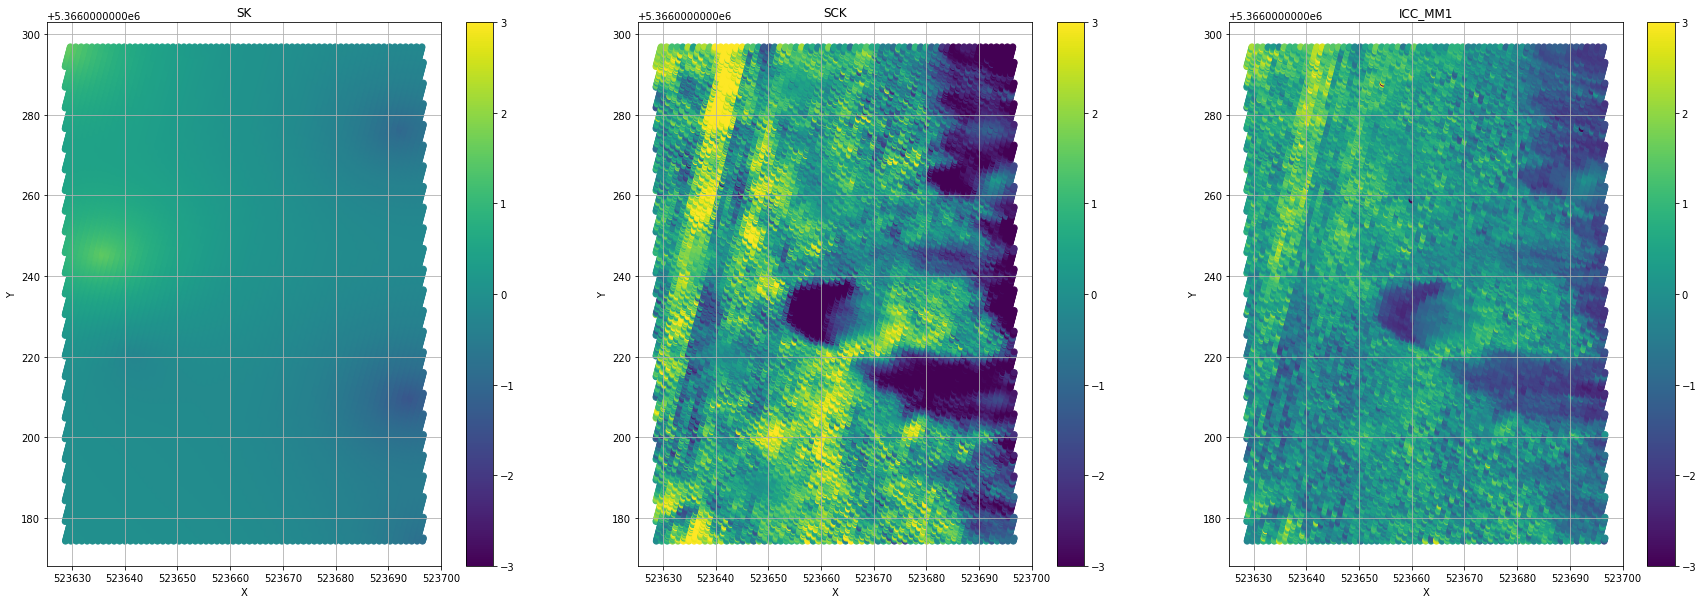

In [109]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,3, figsize = (30,10))
for i,types in enumerate(ktypes) :
    df_kriging["Estimate_"+types] = ktypes_vals_dict[types]["Estimate"]
    Z = df_kriging["Estimate_"+types].values
    
    img0 = ax[i].scatter(x_ech, y_ech,c = Z , vmin = -3, vmax = 3)
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('Y')
    ax[i].grid()
    ax[i].set_title(types)
    fig.colorbar(img0, ax=ax[i])

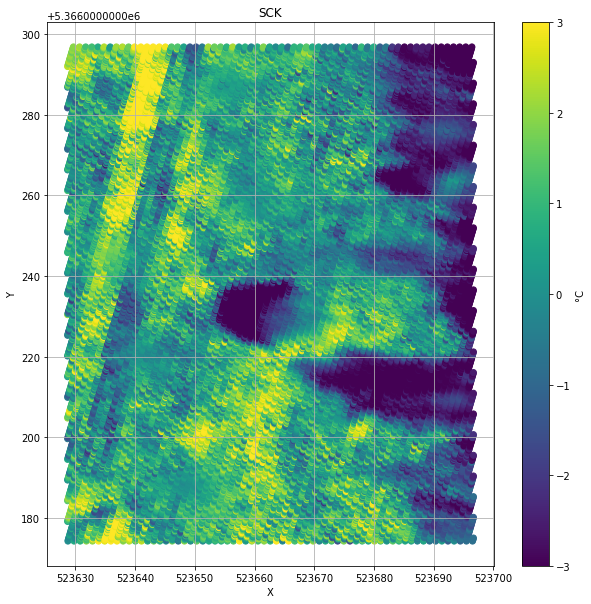

In [151]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,1, figsize = (10,10))
types = "SCK"
df_kriging["Estimate_"+types] = ktypes_vals_dict[types]["Estimate"]
Z = df_kriging["Estimate_"+types].values

img0 = ax.scatter(x_ech, y_ech,c = Z , vmin = -3, vmax = 3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.set_title(types)
fig.colorbar(img0, ax=ax, label = "°C")

In [113]:
print("Z max :",Z.max())
print("Z min :",Z.min())

Z max : 3.6791983396736505
Z min : -13.429891349289873


In [114]:
k_p

8